In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))

In [3]:
lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [4]:
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)

In [5]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


In [6]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))

In [7]:
class GAN_Pure(GAN):
    def __init__(self, ni_D, nh_D, nh_G):
        '''
        Discriminator input is not added
        '''
        super().__init__(ni_D, nh_D, nh_G)

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        # D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

In [8]:
class Machine_Pure(Machine):
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN_Pure(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.014556472383957, 1.2533369818574238)
Mean and Std of Gen: (0.0076147467, 0.030422602)


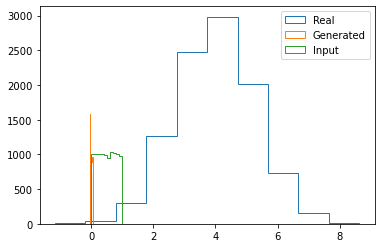

Stage 1 (Epoch: 200)
Mean and Std of Real: (3.9814216916966965, 1.2461498224802292)
Mean and Std of Gen: (-0.0032640067, 0.003518534)


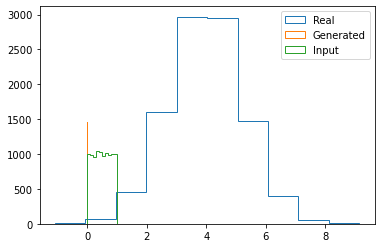

Stage 2 (Epoch: 400)
Mean and Std of Real: (3.958947875745826, 1.2431341210241365)
Mean and Std of Gen: (0.020114344, 0.010754167)


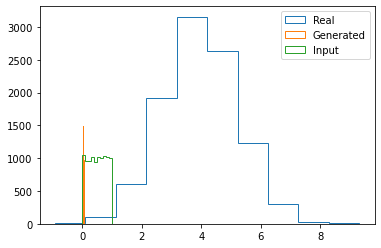

Stage 3 (Epoch: 600)
Mean and Std of Real: (3.9895449796169125, 1.237051261182389)
Mean and Std of Gen: (-0.033050664, 0.043926977)


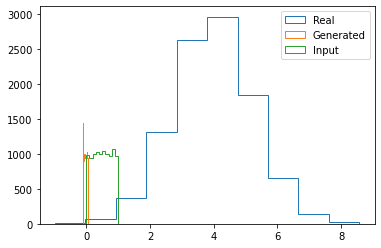

Stage 4 (Epoch: 800)
Mean and Std of Real: (3.9926336778978437, 1.2382775669119033)
Mean and Std of Gen: (0.031177215, 0.080924645)


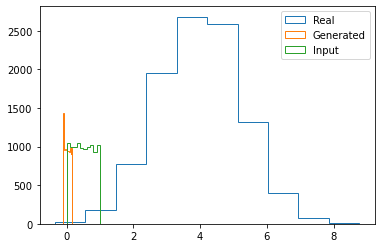

Stage 5 (Epoch: 1000)
Mean and Std of Real: (4.0119682180028375, 1.2479646146753554)
Mean and Std of Gen: (0.2504325, 0.14674103)


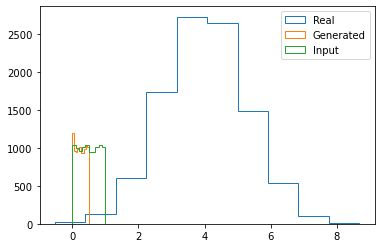

Stage 6 (Epoch: 1200)
Mean and Std of Real: (3.994846679974615, 1.2722692995982647)
Mean and Std of Gen: (0.7093157, 0.44574574)


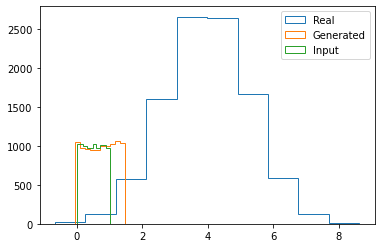

Stage 7 (Epoch: 1400)
Mean and Std of Real: (3.9721951381460894, 1.258278636191063)
Mean and Std of Gen: (1.5868332, 0.7726991)


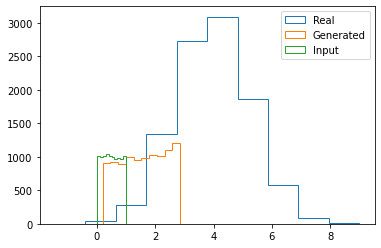

Stage 8 (Epoch: 1600)
Mean and Std of Real: (3.9957096391486315, 1.2397587924074578)
Mean and Std of Gen: (2.3647993, 1.0148349)


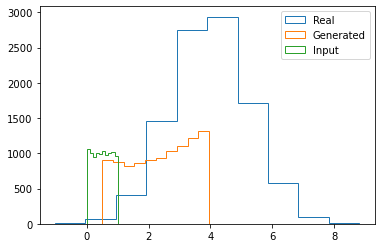

Stage 9 (Epoch: 1800)
Mean and Std of Real: (4.000113879191314, 1.2531957840100298)
Mean and Std of Gen: (3.181184, 1.1729296)


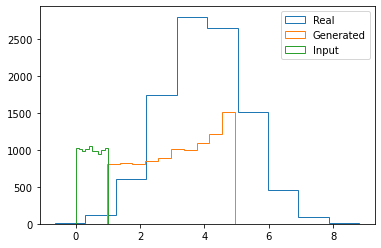

Stage 10 (Epoch: 2000)
Mean and Std of Real: (3.9990041833595904, 1.2340689260183797)
Mean and Std of Gen: (3.9552035, 1.2676523)


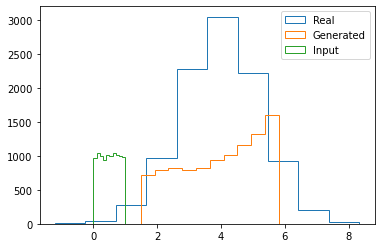

Stage 11 (Epoch: 2200)
Mean and Std of Real: (3.9859597486322875, 1.2598412911128174)
Mean and Std of Gen: (4.661456, 1.3190687)


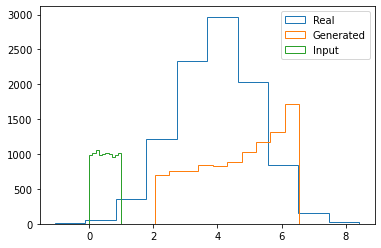

Stage 12 (Epoch: 2400)
Mean and Std of Real: (4.010827225197364, 1.228004476441979)
Mean and Std of Gen: (5.156153, 1.4361395)


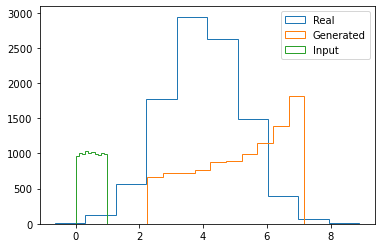

Stage 13 (Epoch: 2600)
Mean and Std of Real: (3.997159929454106, 1.2549552112275744)
Mean and Std of Gen: (5.4426947, 1.4785559)


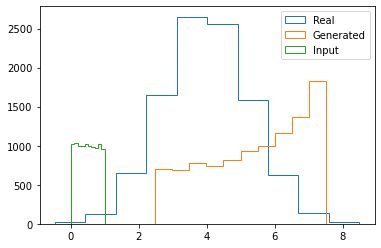

Stage 14 (Epoch: 2800)
Mean and Std of Real: (3.9921478952677587, 1.2546107495671923)
Mean and Std of Gen: (5.7990465, 1.502242)


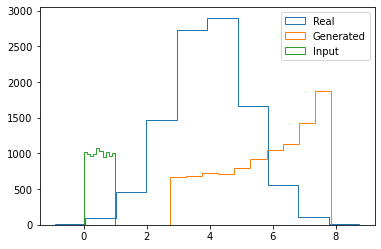

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.011684462150764, 1.2405852649875138)
Mean and Std of Gen: (5.948176, 1.5488167)


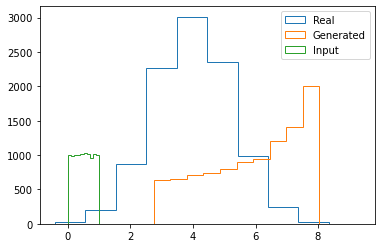

Stage 16 (Epoch: 3200)
Mean and Std of Real: (3.9896850403738817, 1.2553053535667016)
Mean and Std of Gen: (5.8810954, 1.5677803)


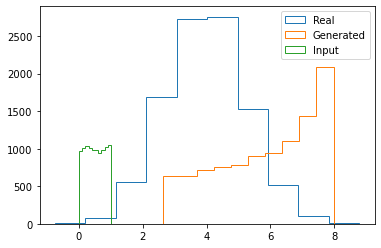

Stage 17 (Epoch: 3400)
Mean and Std of Real: (3.9693781694254366, 1.2693605453071715)
Mean and Std of Gen: (5.997829, 1.460133)


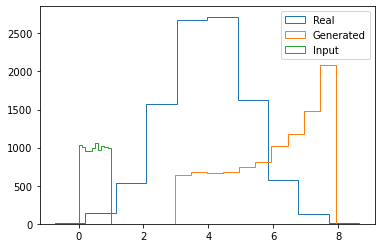

Stage 18 (Epoch: 3600)
Mean and Std of Real: (4.023176737437326, 1.2473133564428958)
Mean and Std of Gen: (5.6127663, 1.5957103)


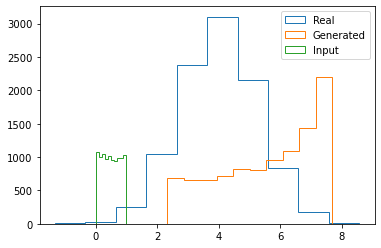

Stage 19 (Epoch: 3800)
Mean and Std of Real: (3.992069291080493, 1.2606121905090188)
Mean and Std of Gen: (5.598262, 1.4656535)


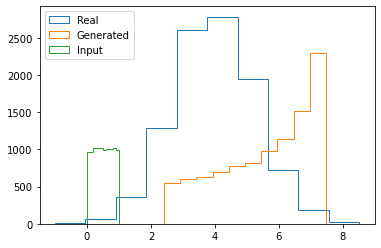

Stage 20 (Epoch: 4000)
Mean and Std of Real: (3.9909090243943703, 1.2464766297970937)
Mean and Std of Gen: (5.512175, 1.4639636)


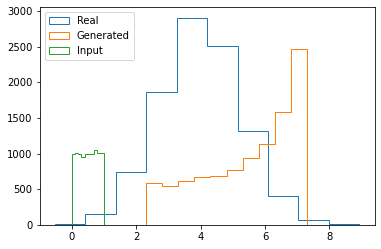

Stage 21 (Epoch: 4200)
Mean and Std of Real: (4.007813487195359, 1.2401422388193128)
Mean and Std of Gen: (5.2543497, 1.5053854)


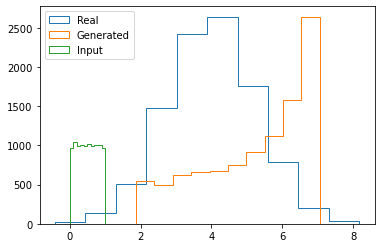

Stage 22 (Epoch: 4400)
Mean and Std of Real: (3.995843028458989, 1.2548410180528826)
Mean and Std of Gen: (5.3749175, 1.3763192)


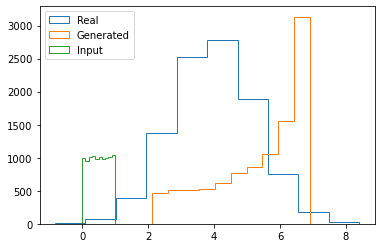

Stage 23 (Epoch: 4600)
Mean and Std of Real: (4.009755805543492, 1.2463965820390244)
Mean and Std of Gen: (5.071951, 1.4768972)


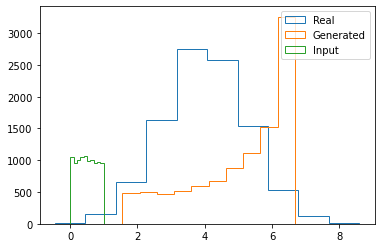

Stage 24 (Epoch: 4800)
Mean and Std of Real: (3.994861333221418, 1.2624943834730789)
Mean and Std of Gen: (5.1038094, 1.4098966)


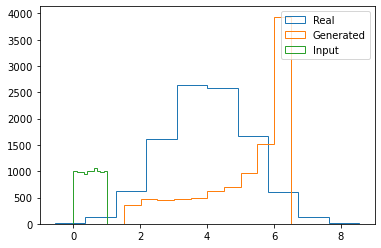

Stage 25 (Epoch: 5000)
Mean and Std of Real: (4.0081998596924295, 1.2700293444182826)
Mean and Std of Gen: (5.1254783, 1.3562249)


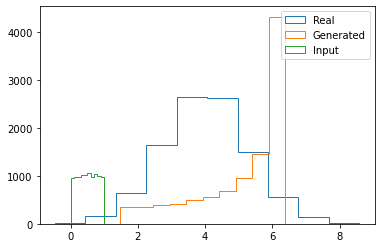

Stage 26 (Epoch: 5200)
Mean and Std of Real: (4.002560328056, 1.2441551769273236)
Mean and Std of Gen: (4.8781686, 1.4552875)


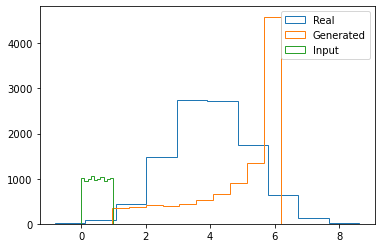

Stage 27 (Epoch: 5400)
Mean and Std of Real: (3.9961820414803224, 1.2387623417242795)
Mean and Std of Gen: (5.0461373, 1.3319314)


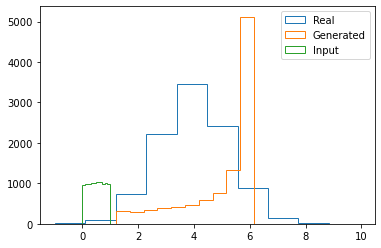

Stage 28 (Epoch: 5600)
Mean and Std of Real: (4.020227499261047, 1.258346447249)
Mean and Std of Gen: (4.9288073, 1.3851544)


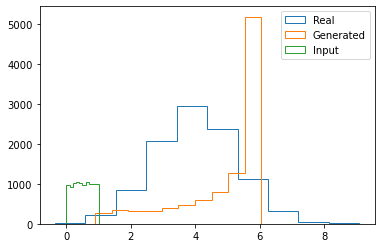

Stage 29 (Epoch: 5800)
Mean and Std of Real: (4.0246227581671565, 1.2471480802220039)
Mean and Std of Gen: (4.753583, 1.3619753)


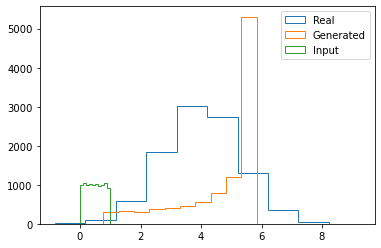

Stage 30 (Epoch: 6000)
Mean and Std of Real: (4.003139928828909, 1.2500978423974471)
Mean and Std of Gen: (4.7886543, 1.3193536)


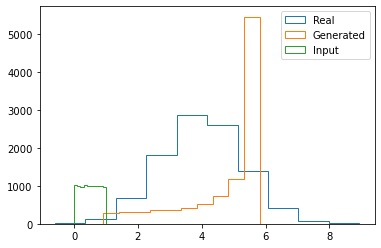

Stage 31 (Epoch: 6200)
Mean and Std of Real: (3.977473968331045, 1.249685916037122)
Mean and Std of Gen: (4.776671, 1.317068)


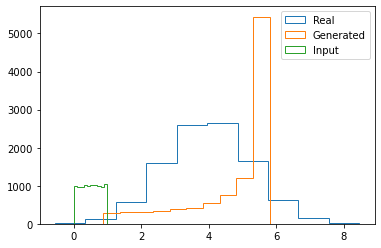

Stage 32 (Epoch: 6400)
Mean and Std of Real: (4.005599441504691, 1.2537013191819473)
Mean and Std of Gen: (4.6288443, 1.3732581)


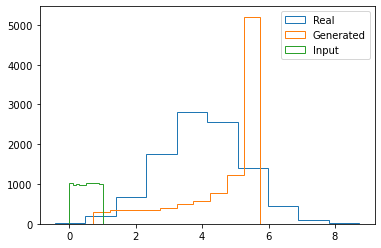

Stage 33 (Epoch: 6600)
Mean and Std of Real: (4.000079964477619, 1.2356654110948413)
Mean and Std of Gen: (4.4997916, 1.3486462)


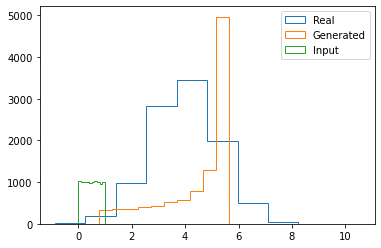

Stage 34 (Epoch: 6800)
Mean and Std of Real: (3.9910013453980957, 1.2481790242698223)
Mean and Std of Gen: (4.5921125, 1.3099126)


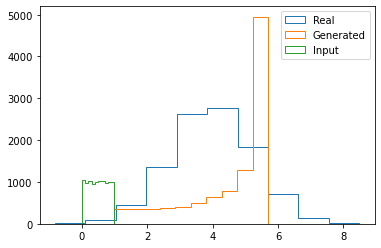

Stage 35 (Epoch: 7000)
Mean and Std of Real: (3.9968083999646855, 1.241822929277833)
Mean and Std of Gen: (4.5978837, 1.3294615)


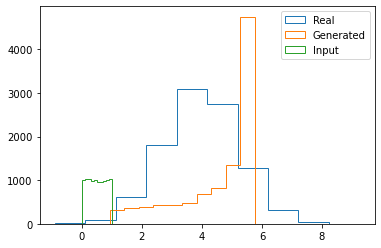

Stage 36 (Epoch: 7200)
Mean and Std of Real: (3.9902925306018036, 1.2318498726914109)
Mean and Std of Gen: (4.524987, 1.327326)


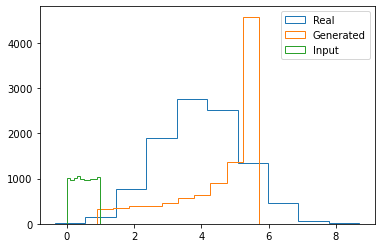

Stage 37 (Epoch: 7400)
Mean and Std of Real: (4.001626769851581, 1.2384412038465507)
Mean and Std of Gen: (4.5351877, 1.315004)


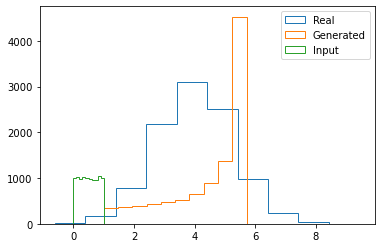

Stage 38 (Epoch: 7600)
Mean and Std of Real: (4.027104348219738, 1.252183471970483)
Mean and Std of Gen: (4.352281, 1.3029872)


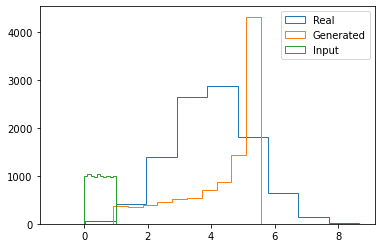

Stage 39 (Epoch: 7800)
Mean and Std of Real: (3.99883482917684, 1.2434515826428512)
Mean and Std of Gen: (4.110545, 1.3110696)


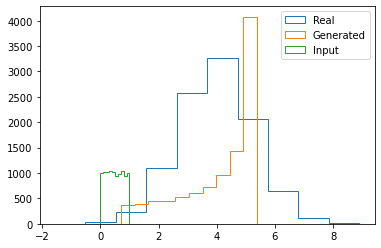

Stage 40 (Epoch: 8000)
Mean and Std of Real: (4.001634321963737, 1.257481221191243)
Mean and Std of Gen: (4.159836, 1.2965556)


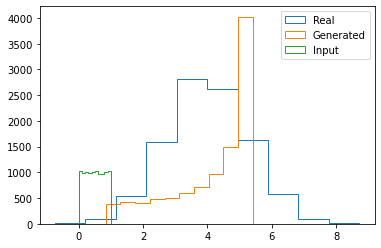

Stage 41 (Epoch: 8200)
Mean and Std of Real: (4.010704306895313, 1.2717463540535316)
Mean and Std of Gen: (4.102133, 1.2716467)


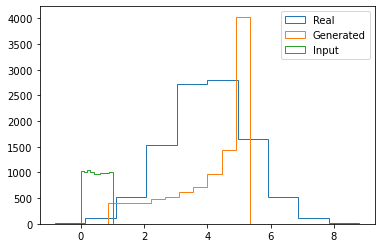

Stage 42 (Epoch: 8400)
Mean and Std of Real: (3.9858886817464327, 1.2442752386087317)
Mean and Std of Gen: (4.1114354, 1.2396563)


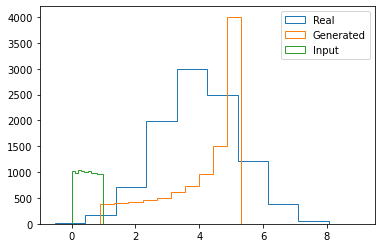

Stage 43 (Epoch: 8600)
Mean and Std of Real: (3.9983168349819325, 1.252444468417698)
Mean and Std of Gen: (4.0317435, 1.2387397)


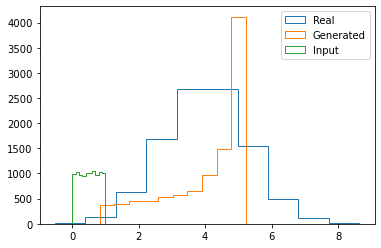

Stage 44 (Epoch: 8800)
Mean and Std of Real: (3.999446057117982, 1.2641806086043108)
Mean and Std of Gen: (4.0155478, 1.2201579)


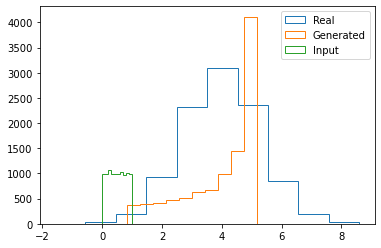

Stage 45 (Epoch: 9000)
Mean and Std of Real: (4.002553168699369, 1.2591090766976885)
Mean and Std of Gen: (3.7653234, 1.2617338)


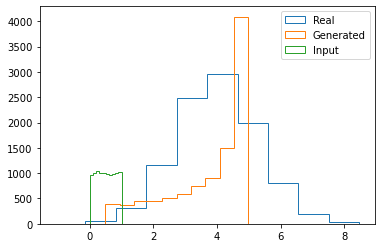

Stage 46 (Epoch: 9200)
Mean and Std of Real: (4.0087524161654375, 1.2386733992018897)
Mean and Std of Gen: (4.047481, 1.1897782)


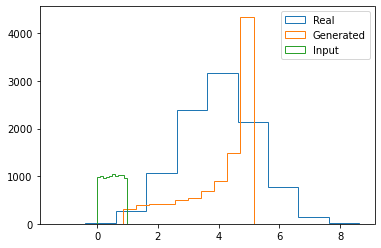

Stage 47 (Epoch: 9400)
Mean and Std of Real: (4.003166328493978, 1.263743078707139)
Mean and Std of Gen: (3.9414742, 1.2355107)


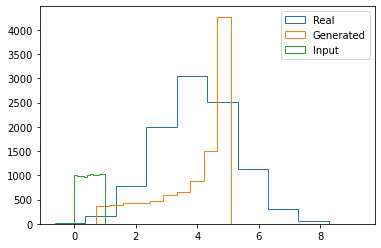

Stage 48 (Epoch: 9600)
Mean and Std of Real: (4.004868128042929, 1.2422029572525473)
Mean and Std of Gen: (3.9495964, 1.255438)


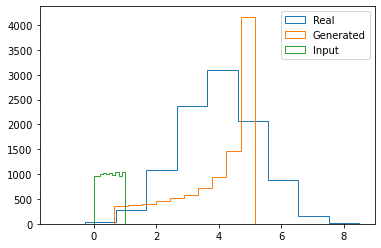

Stage 49 (Epoch: 9800)
Mean and Std of Real: (4.003933209071728, 1.244085223967001)
Mean and Std of Gen: (4.0333242, 1.2285256)


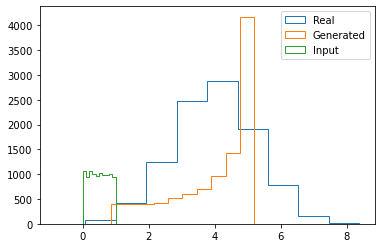

Stage 50 (Epoch: 10000)
Mean and Std of Real: (3.9942726572568774, 1.2505135217770174)
Mean and Std of Gen: (3.8492837, 1.2863328)


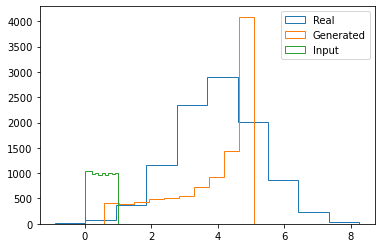

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.007050991609965, 1.2455623866730945)
Mean and Std of Gen: (3.9781003, 1.2237616)


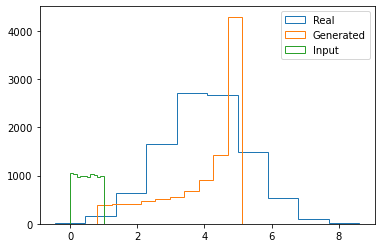

Stage 52 (Epoch: 10400)
Mean and Std of Real: (4.0040686885086645, 1.2554848044461815)
Mean and Std of Gen: (3.8794448, 1.2762058)


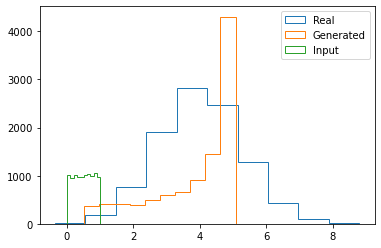

Stage 53 (Epoch: 10600)
Mean and Std of Real: (4.002047921564249, 1.2543029175819145)
Mean and Std of Gen: (3.9256988, 1.222856)


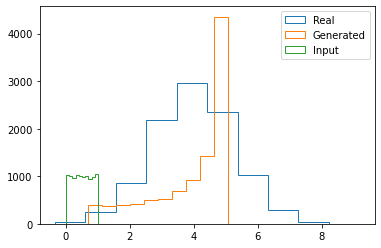

Stage 54 (Epoch: 10800)
Mean and Std of Real: (4.003400750580913, 1.2513600346121792)
Mean and Std of Gen: (4.009834, 1.2575796)


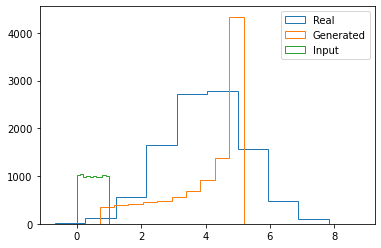

Stage 55 (Epoch: 11000)
Mean and Std of Real: (3.992103678067196, 1.2477828234230848)
Mean and Std of Gen: (3.9657657, 1.25902)


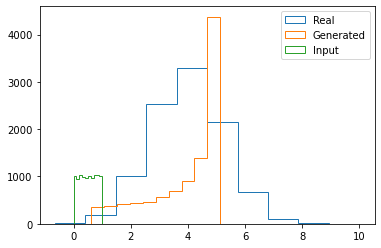

Stage 56 (Epoch: 11200)
Mean and Std of Real: (4.007752600781601, 1.2518765142186268)
Mean and Std of Gen: (4.14781, 1.2516367)


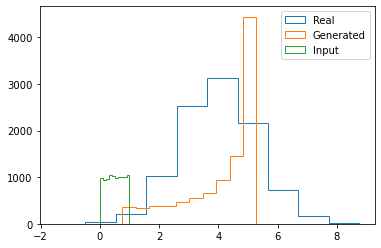

Stage 57 (Epoch: 11400)
Mean and Std of Real: (4.003595799992608, 1.2479787685918302)
Mean and Std of Gen: (4.1035943, 1.2748058)


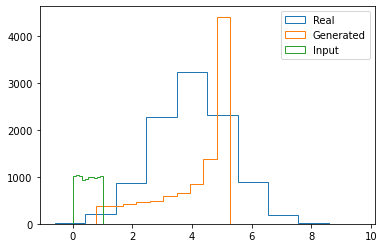

Stage 58 (Epoch: 11600)
Mean and Std of Real: (3.9948644800853885, 1.24346759098115)
Mean and Std of Gen: (4.067012, 1.2740754)


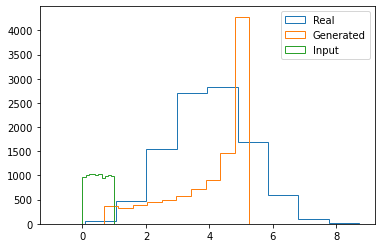

Stage 59 (Epoch: 11800)
Mean and Std of Real: (3.9695407522680624, 1.2403049476702201)
Mean and Std of Gen: (4.0527067, 1.2669755)


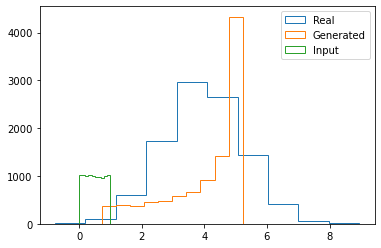

Stage 60 (Epoch: 12000)
Mean and Std of Real: (4.010575081598418, 1.2515096910928263)
Mean and Std of Gen: (4.020842, 1.249282)


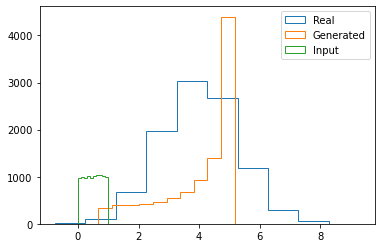

Stage 61 (Epoch: 12200)
Mean and Std of Real: (4.017480329362672, 1.2591976048089792)
Mean and Std of Gen: (4.0566916, 1.2261262)


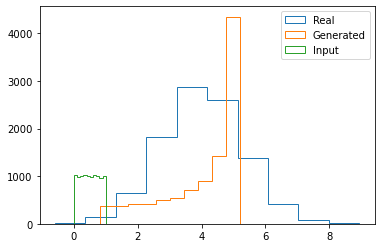

Stage 62 (Epoch: 12400)
Mean and Std of Real: (3.9983445154204236, 1.2462445452837811)
Mean and Std of Gen: (3.8755536, 1.2815061)


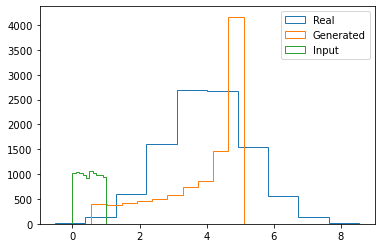

Stage 63 (Epoch: 12600)
Mean and Std of Real: (3.987324574120094, 1.2435410090976138)
Mean and Std of Gen: (3.919228, 1.2369179)


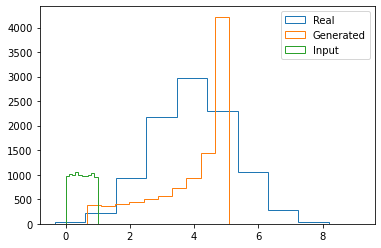

Stage 64 (Epoch: 12800)
Mean and Std of Real: (4.011688512186382, 1.2542229118951747)
Mean and Std of Gen: (3.926288, 1.2646791)


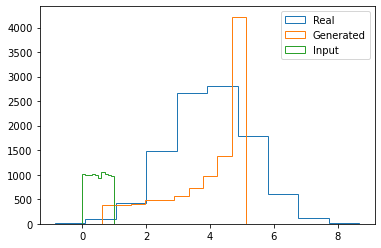

Stage 65 (Epoch: 13000)
Mean and Std of Real: (3.9931743308838836, 1.2364088921486966)
Mean and Std of Gen: (4.044636, 1.2356483)


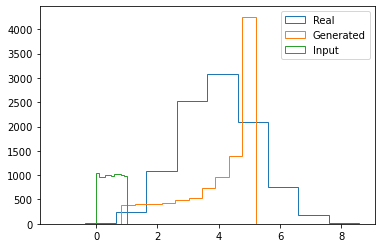

Stage 66 (Epoch: 13200)
Mean and Std of Real: (3.992794350349482, 1.266480739290653)
Mean and Std of Gen: (3.837647, 1.2694073)


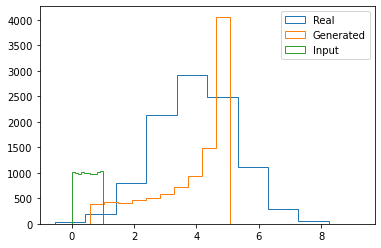

Stage 67 (Epoch: 13400)
Mean and Std of Real: (3.9869506572362794, 1.238571255203159)
Mean and Std of Gen: (3.97126, 1.2123013)


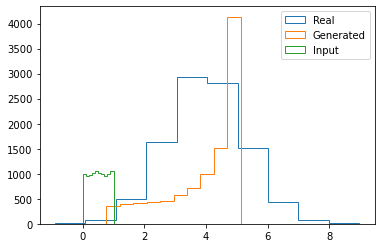

Stage 68 (Epoch: 13600)
Mean and Std of Real: (3.993047433801531, 1.2374202006951052)
Mean and Std of Gen: (3.8726509, 1.2095611)


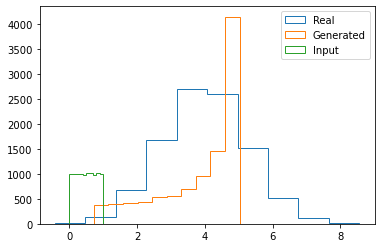

Stage 69 (Epoch: 13800)
Mean and Std of Real: (3.998674812800411, 1.253474041101985)
Mean and Std of Gen: (3.7583203, 1.2825832)


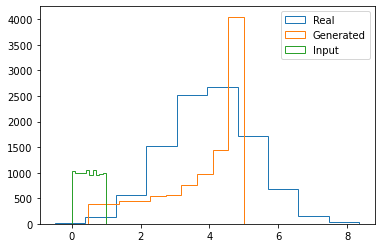

Stage 70 (Epoch: 14000)
Mean and Std of Real: (4.001710862536976, 1.2498496789413234)
Mean and Std of Gen: (4.011398, 1.2476484)


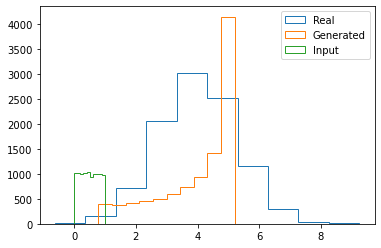

Stage 71 (Epoch: 14200)
Mean and Std of Real: (3.997471187583311, 1.2423166432288424)
Mean and Std of Gen: (4.042205, 1.2466094)


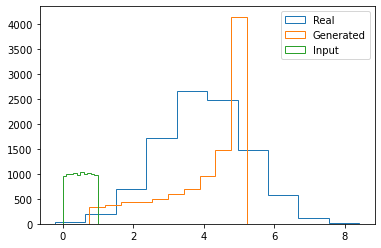

Stage 72 (Epoch: 14400)
Mean and Std of Real: (4.00341414426498, 1.250760676208768)
Mean and Std of Gen: (3.964373, 1.2231752)


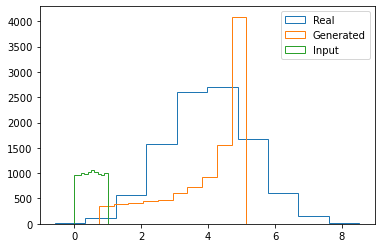

Stage 73 (Epoch: 14600)
Mean and Std of Real: (4.014941408183635, 1.2486309997773586)
Mean and Std of Gen: (3.9450648, 1.2560017)


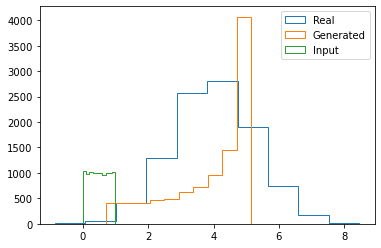

Stage 74 (Epoch: 14800)
Mean and Std of Real: (3.9848229428211153, 1.2444487695637538)
Mean and Std of Gen: (3.9861906, 1.2697079)


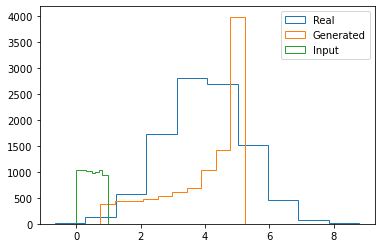

Stage 75 (Epoch: 15000)
Mean and Std of Real: (4.0120511921613895, 1.2630450002778904)
Mean and Std of Gen: (4.079251, 1.2253711)


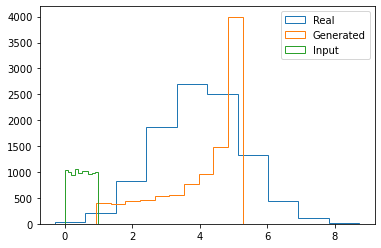

Stage 76 (Epoch: 15200)
Mean and Std of Real: (4.029057232651712, 1.246104735500449)
Mean and Std of Gen: (3.9138012, 1.3393776)


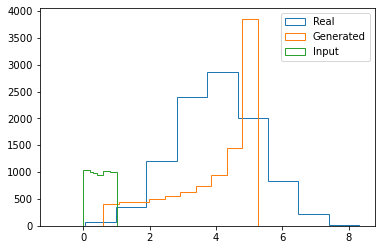

Stage 77 (Epoch: 15400)
Mean and Std of Real: (3.9889921580954164, 1.248953975756823)
Mean and Std of Gen: (4.2727256, 1.2025467)


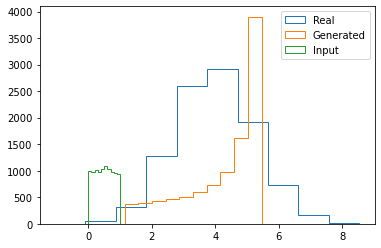

Stage 78 (Epoch: 15600)
Mean and Std of Real: (4.002265605762493, 1.254863153125029)
Mean and Std of Gen: (3.9159262, 1.2604703)


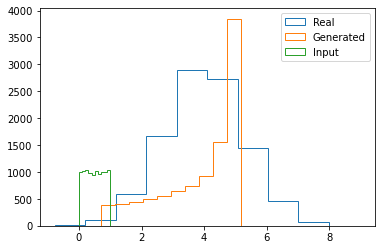

Stage 79 (Epoch: 15800)
Mean and Std of Real: (4.001082723588288, 1.2326925741245223)
Mean and Std of Gen: (4.042583, 1.2160568)


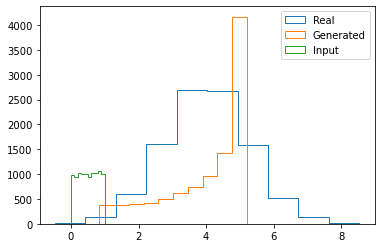

Stage 80 (Epoch: 16000)
Mean and Std of Real: (3.996188104108391, 1.2448222467135415)
Mean and Std of Gen: (3.8233194, 1.2890731)


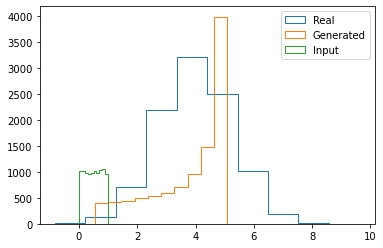

Stage 81 (Epoch: 16200)
Mean and Std of Real: (3.995911827956855, 1.234556870665399)
Mean and Std of Gen: (4.006599, 1.2206911)


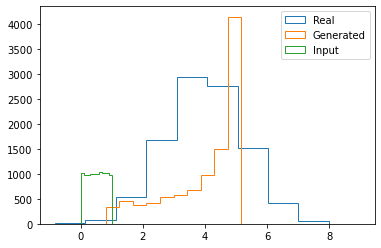

Stage 82 (Epoch: 16400)
Mean and Std of Real: (4.006334058557, 1.2545033215767494)
Mean and Std of Gen: (3.926162, 1.204725)


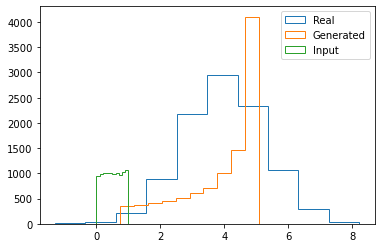

Stage 83 (Epoch: 16600)
Mean and Std of Real: (4.008452647566874, 1.2518333509205803)
Mean and Std of Gen: (3.9546032, 1.2199033)


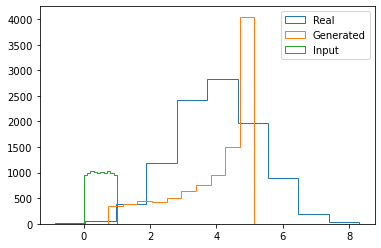

Stage 84 (Epoch: 16800)
Mean and Std of Real: (4.010986068983625, 1.2585906153418454)
Mean and Std of Gen: (3.854622, 1.2036389)


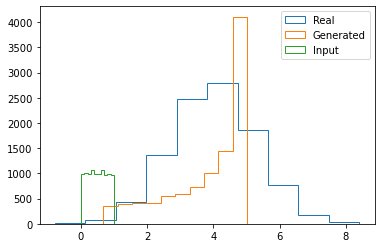

Stage 85 (Epoch: 17000)
Mean and Std of Real: (4.0013573101830575, 1.2537920670034708)
Mean and Std of Gen: (3.8027613, 1.2302269)


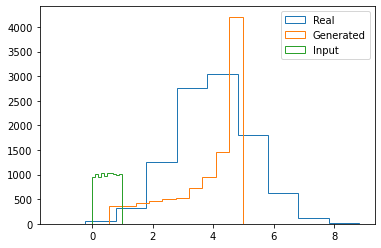

Stage 86 (Epoch: 17200)
Mean and Std of Real: (3.9779392486061877, 1.2625292592523203)
Mean and Std of Gen: (3.849722, 1.2208147)


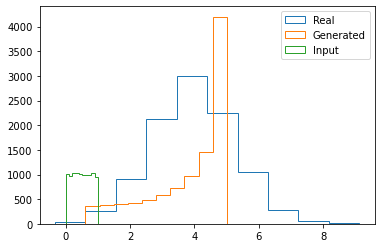

Stage 87 (Epoch: 17400)
Mean and Std of Real: (3.99286400167146, 1.2552249998775058)
Mean and Std of Gen: (3.9829216, 1.2589316)


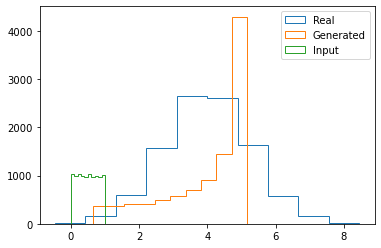

Stage 88 (Epoch: 17600)
Mean and Std of Real: (3.9980948172298043, 1.2498949092986908)
Mean and Std of Gen: (4.1075063, 1.2444444)


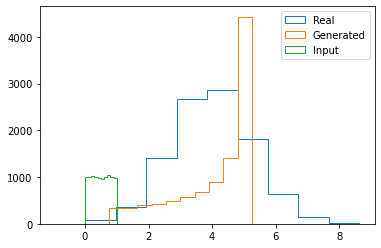

Stage 89 (Epoch: 17800)
Mean and Std of Real: (4.002292919116451, 1.2529718726010122)
Mean and Std of Gen: (4.079494, 1.2755593)


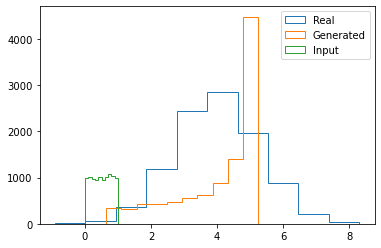

Stage 90 (Epoch: 18000)
Mean and Std of Real: (3.967520011106816, 1.2485468955386163)
Mean and Std of Gen: (4.0023856, 1.273451)


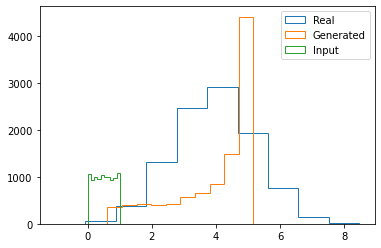

Stage 91 (Epoch: 18200)
Mean and Std of Real: (4.011866199571245, 1.243800874053499)
Mean and Std of Gen: (3.8929708, 1.276655)


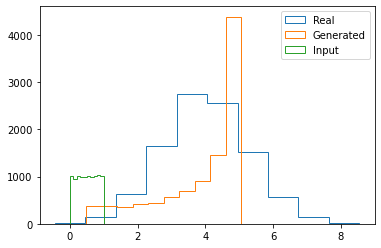

Stage 92 (Epoch: 18400)
Mean and Std of Real: (4.000154670323026, 1.2518892394362886)
Mean and Std of Gen: (3.8353672, 1.2400566)


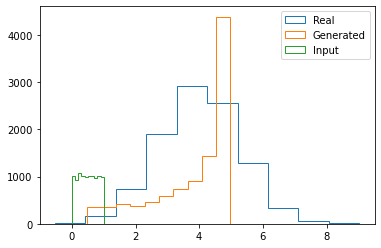

Stage 93 (Epoch: 18600)
Mean and Std of Real: (3.988218521944849, 1.2440210668673573)
Mean and Std of Gen: (3.8990786, 1.218143)


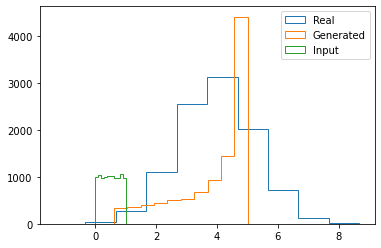

Stage 94 (Epoch: 18800)
Mean and Std of Real: (3.991594325388565, 1.2463437167164475)
Mean and Std of Gen: (4.0034103, 1.2052157)


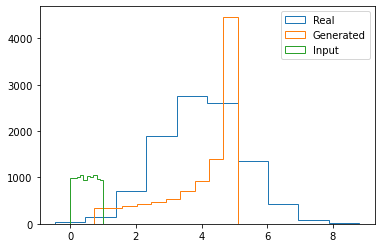

Stage 95 (Epoch: 19000)
Mean and Std of Real: (4.010437372698858, 1.2415131897746716)
Mean and Std of Gen: (3.9659019, 1.2479864)


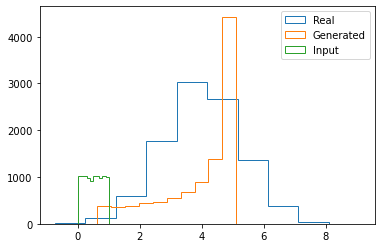

Stage 96 (Epoch: 19200)
Mean and Std of Real: (3.996010103921524, 1.2639507385838256)
Mean and Std of Gen: (3.9868836, 1.2748003)


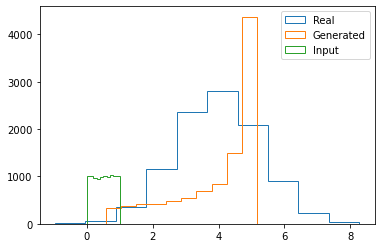

Stage 97 (Epoch: 19400)
Mean and Std of Real: (3.993977518956366, 1.2544384377174045)
Mean and Std of Gen: (4.0227795, 1.2393646)


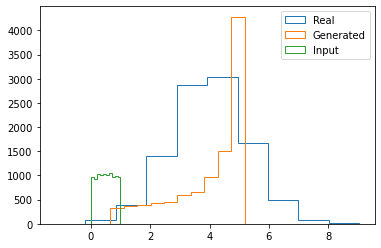

Stage 98 (Epoch: 19600)
Mean and Std of Real: (3.996865136567183, 1.2566634566349522)
Mean and Std of Gen: (3.9790032, 1.2675326)


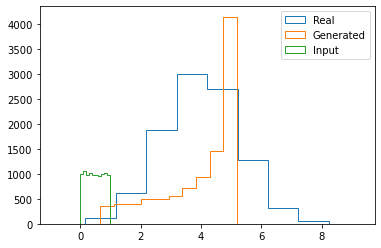

Stage 99 (Epoch: 19800)
Mean and Std of Real: (4.012796614507316, 1.2530794961743221)
Mean and Std of Gen: (4.004596, 1.2175651)


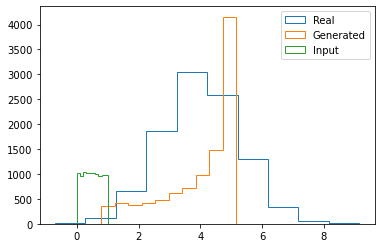

Stage 100 (Epoch: 20000)
Mean and Std of Real: (4.003818760335297, 1.2614878308160073)
Mean and Std of Gen: (3.8221622, 1.2308915)


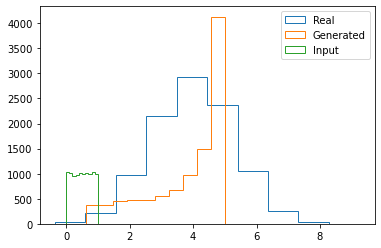

Stage 101 (Epoch: 20200)
Mean and Std of Real: (3.991202945504629, 1.2450111540047044)
Mean and Std of Gen: (3.7434485, 1.261331)


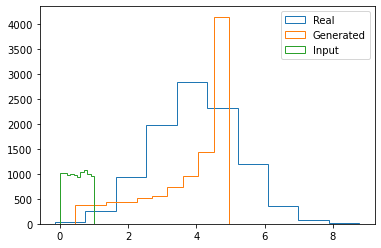

Stage 102 (Epoch: 20400)
Mean and Std of Real: (3.9651725708579506, 1.2565133267216868)
Mean and Std of Gen: (3.856502, 1.2633836)


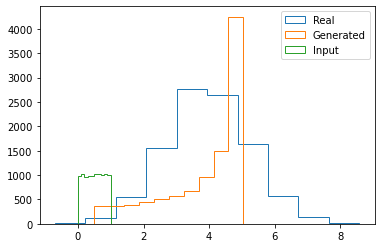

Stage 103 (Epoch: 20600)
Mean and Std of Real: (3.982798328877872, 1.2439034676361882)
Mean and Std of Gen: (3.8254836, 1.2600832)


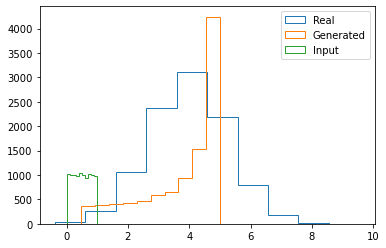

Stage 104 (Epoch: 20800)
Mean and Std of Real: (3.998020153691759, 1.2558323264342672)
Mean and Std of Gen: (3.9736862, 1.2115496)


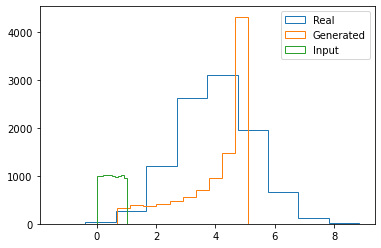

Stage 105 (Epoch: 21000)
Mean and Std of Real: (3.9985006399081824, 1.2414267398929215)
Mean and Std of Gen: (4.0539913, 1.282644)


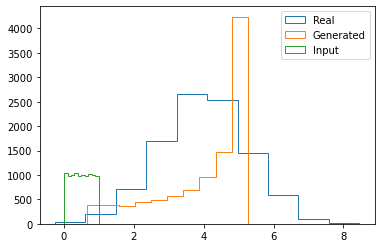

Stage 106 (Epoch: 21200)
Mean and Std of Real: (4.0088757172009455, 1.2413382313689025)
Mean and Std of Gen: (4.1433992, 1.252935)


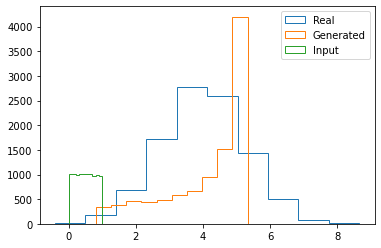

Stage 107 (Epoch: 21400)
Mean and Std of Real: (4.007873878768215, 1.2429628356849802)
Mean and Std of Gen: (3.984848, 1.2702557)


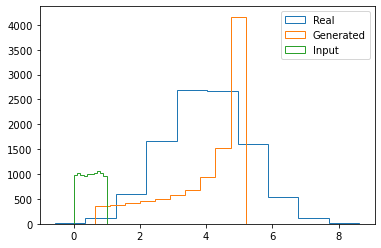

Stage 108 (Epoch: 21600)
Mean and Std of Real: (3.981423183296417, 1.252432892622646)
Mean and Std of Gen: (3.9433274, 1.2707956)


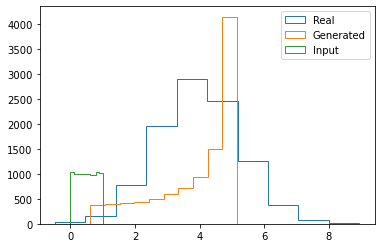

Stage 109 (Epoch: 21800)
Mean and Std of Real: (3.9853758753993245, 1.2483814020277715)
Mean and Std of Gen: (3.9373364, 1.2538443)


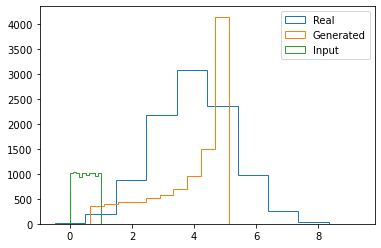

Stage 110 (Epoch: 22000)
Mean and Std of Real: (3.9844150177885886, 1.2554707835910646)
Mean and Std of Gen: (3.9544625, 1.2391095)


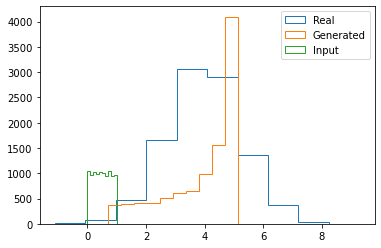

Stage 111 (Epoch: 22200)
Mean and Std of Real: (4.006011728785874, 1.2423016902586699)
Mean and Std of Gen: (3.9446485, 1.234718)


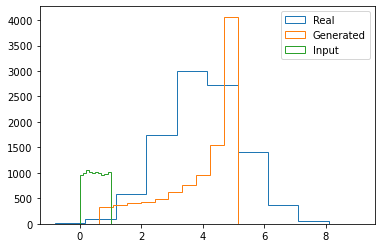

Stage 112 (Epoch: 22400)
Mean and Std of Real: (4.004972095967318, 1.2469634770226738)
Mean and Std of Gen: (4.051586, 1.243617)


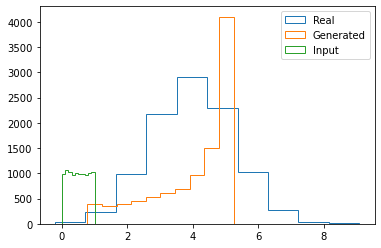

Stage 113 (Epoch: 22600)
Mean and Std of Real: (3.9887150460708583, 1.2563065761012382)
Mean and Std of Gen: (4.001078, 1.2346424)


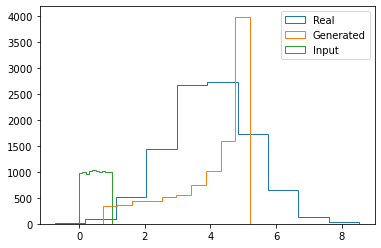

Stage 114 (Epoch: 22800)
Mean and Std of Real: (3.9938238888490036, 1.2620215591440291)
Mean and Std of Gen: (3.9035478, 1.258212)


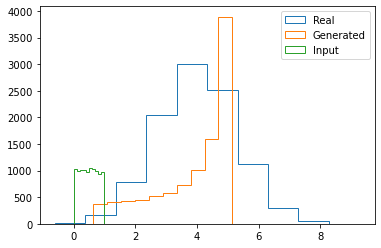

Stage 115 (Epoch: 23000)
Mean and Std of Real: (3.9847878715450498, 1.261492365974657)
Mean and Std of Gen: (3.899793, 1.2636986)


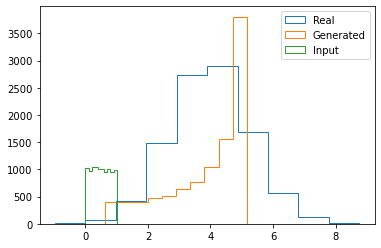

Stage 116 (Epoch: 23200)
Mean and Std of Real: (3.9847015351647532, 1.2488957102991776)
Mean and Std of Gen: (4.117569, 1.2222384)


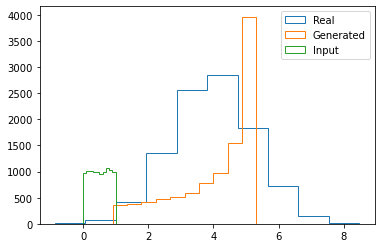

Stage 117 (Epoch: 23400)
Mean and Std of Real: (4.012913831906919, 1.2484659867549952)
Mean and Std of Gen: (3.9461758, 1.2747476)


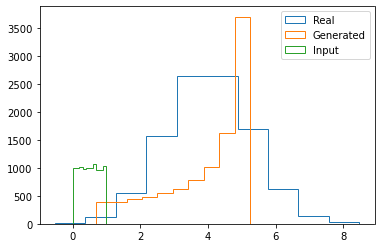

Stage 118 (Epoch: 23600)
Mean and Std of Real: (4.015606766732706, 1.2636355016809449)
Mean and Std of Gen: (4.037537, 1.2310569)


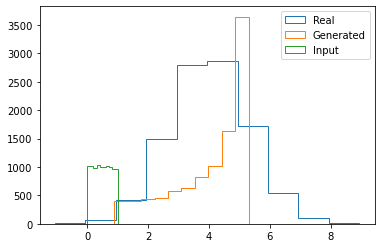

Stage 119 (Epoch: 23800)
Mean and Std of Real: (4.011124282806879, 1.2576290407431954)
Mean and Std of Gen: (3.921935, 1.2701018)


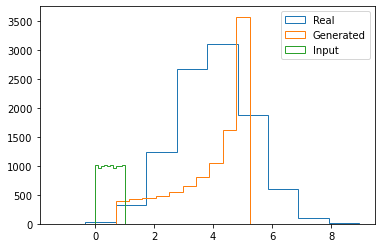

Stage 120 (Epoch: 24000)
Mean and Std of Real: (3.983152164715787, 1.2337353751621138)
Mean and Std of Gen: (3.943868, 1.2233806)


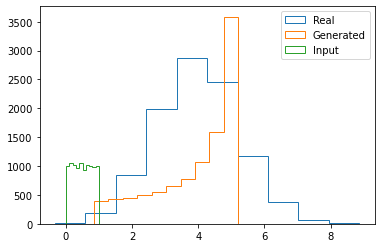

Stage 121 (Epoch: 24200)
Mean and Std of Real: (4.000410717246667, 1.2525945129353533)
Mean and Std of Gen: (3.8532457, 1.2232163)


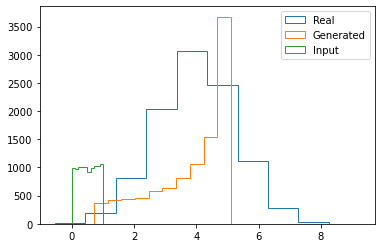

Stage 122 (Epoch: 24400)
Mean and Std of Real: (3.986536225705936, 1.2622694720360181)
Mean and Std of Gen: (3.675419, 1.2383208)


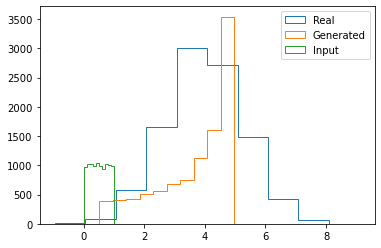

Stage 123 (Epoch: 24600)
Mean and Std of Real: (4.0042857535581105, 1.2381625103973422)
Mean and Std of Gen: (3.8847404, 1.2043223)


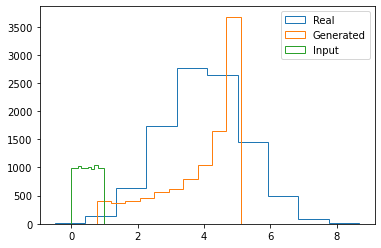

Stage 124 (Epoch: 24800)
Mean and Std of Real: (3.9922927596061983, 1.251298055312692)
Mean and Std of Gen: (3.8464484, 1.2183491)


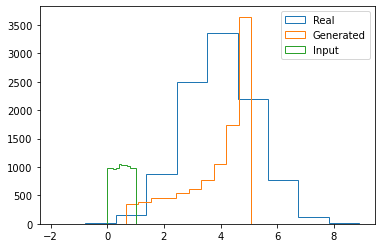

Stage 125 (Epoch: 25000)
Mean and Std of Real: (3.9854312080551435, 1.2544537229183639)
Mean and Std of Gen: (3.811566, 1.2094756)


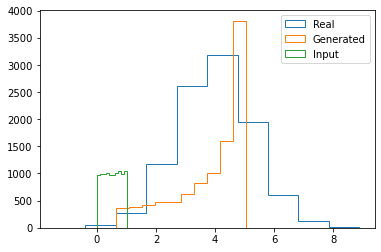

Stage 126 (Epoch: 25200)
Mean and Std of Real: (4.007374210547202, 1.2558094969155462)
Mean and Std of Gen: (3.7661743, 1.2059935)


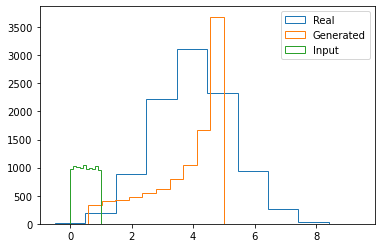

Stage 127 (Epoch: 25400)
Mean and Std of Real: (3.999538805240196, 1.2534568120193044)
Mean and Std of Gen: (3.8852277, 1.2411785)


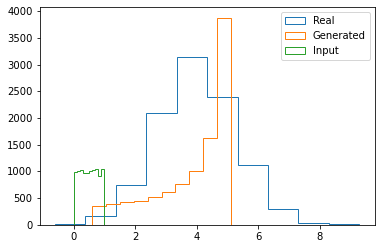

Stage 128 (Epoch: 25600)
Mean and Std of Real: (4.002943833793862, 1.2373270932051739)
Mean and Std of Gen: (3.871209, 1.2412168)


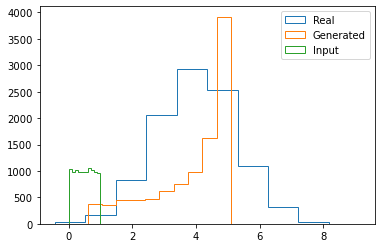

Stage 129 (Epoch: 25800)
Mean and Std of Real: (4.004737104317631, 1.2455372560414295)
Mean and Std of Gen: (3.8125074, 1.2475355)


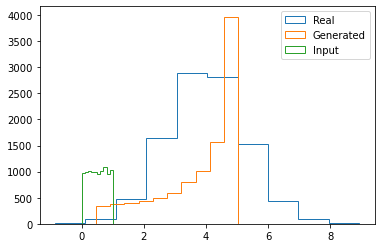

Stage 130 (Epoch: 26000)
Mean and Std of Real: (3.9940363580366056, 1.2364885076656833)
Mean and Std of Gen: (3.8782313, 1.2428219)


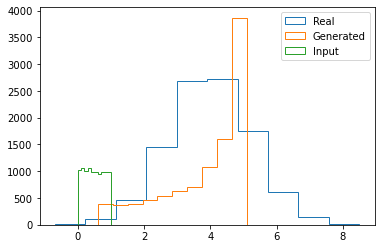

Stage 131 (Epoch: 26200)
Mean and Std of Real: (3.9983754119447723, 1.2610834359616165)
Mean and Std of Gen: (3.9176965, 1.2422222)


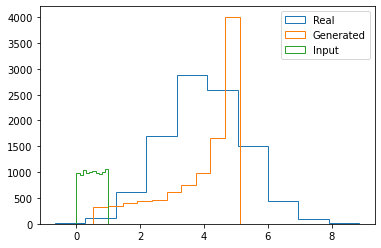

Stage 132 (Epoch: 26400)
Mean and Std of Real: (3.9891860147726796, 1.2518401439359412)
Mean and Std of Gen: (4.0633745, 1.2393987)


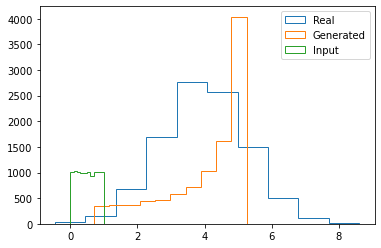

Stage 133 (Epoch: 26600)
Mean and Std of Real: (3.9801536593322724, 1.255926580324514)
Mean and Std of Gen: (4.1872034, 1.2372851)


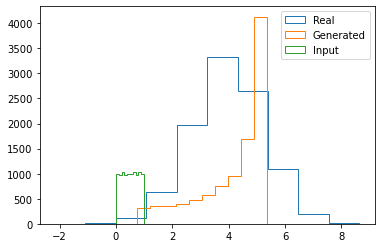

Stage 134 (Epoch: 26800)
Mean and Std of Real: (3.9997099183894473, 1.2511677486985042)
Mean and Std of Gen: (3.9811394, 1.3066206)


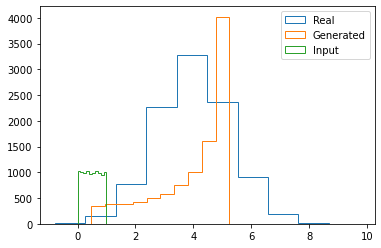

Stage 135 (Epoch: 27000)
Mean and Std of Real: (4.00308108872995, 1.2550001041670251)
Mean and Std of Gen: (4.1509495, 1.2300313)


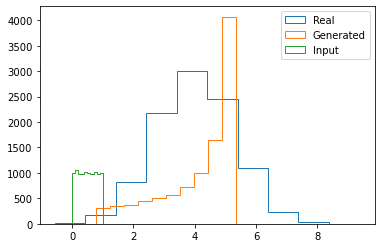

Stage 136 (Epoch: 27200)
Mean and Std of Real: (3.978996176838033, 1.255707531313796)
Mean and Std of Gen: (4.138002, 1.2667687)


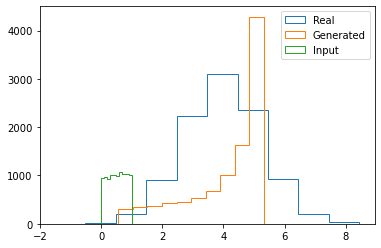

Stage 137 (Epoch: 27400)
Mean and Std of Real: (3.999845511841928, 1.259362199173941)
Mean and Std of Gen: (3.9396589, 1.2716328)


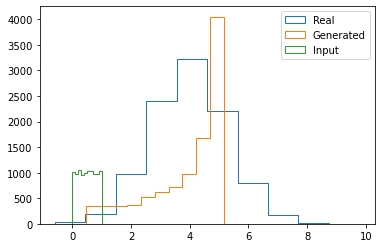

Stage 138 (Epoch: 27600)
Mean and Std of Real: (4.015361736338422, 1.242147052792543)
Mean and Std of Gen: (4.044286, 1.2560122)


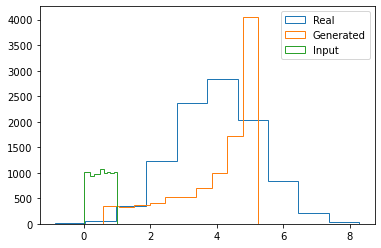

Stage 139 (Epoch: 27800)
Mean and Std of Real: (3.9990080187033987, 1.2487963626688776)
Mean and Std of Gen: (4.069149, 1.2579234)


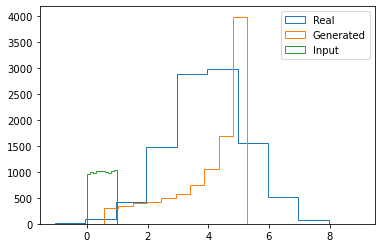

Stage 140 (Epoch: 28000)
Mean and Std of Real: (3.9981033398992563, 1.2365185966560515)
Mean and Std of Gen: (4.1086693, 1.2656204)


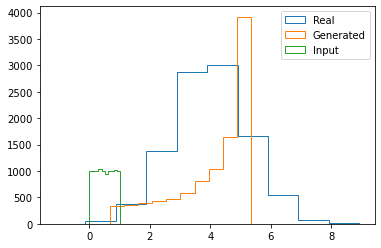

Stage 141 (Epoch: 28200)
Mean and Std of Real: (4.010144405802442, 1.2435319177689488)
Mean and Std of Gen: (4.1835127, 1.2408133)


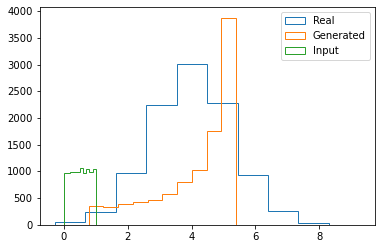

Stage 142 (Epoch: 28400)
Mean and Std of Real: (4.008132177531166, 1.2620965747456379)
Mean and Std of Gen: (3.9781227, 1.2670093)


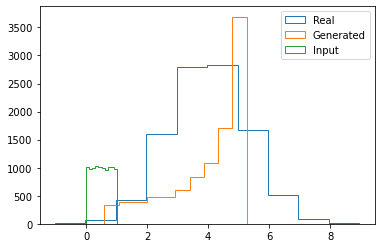

Stage 143 (Epoch: 28600)
Mean and Std of Real: (4.015676148678838, 1.2539428088225988)
Mean and Std of Gen: (3.9691696, 1.1967791)


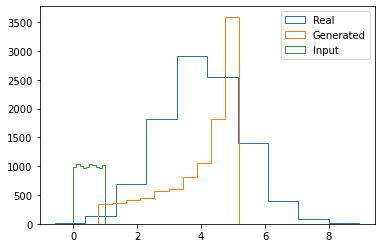

Stage 144 (Epoch: 28800)
Mean and Std of Real: (4.000127585203088, 1.252871512853826)
Mean and Std of Gen: (3.858768, 1.2416085)


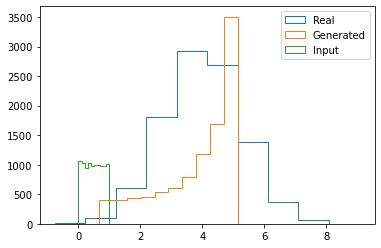

Stage 145 (Epoch: 29000)
Mean and Std of Real: (3.995305118447395, 1.2460377951777732)
Mean and Std of Gen: (3.8204145, 1.2123684)


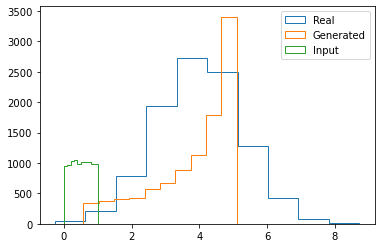

Stage 146 (Epoch: 29200)
Mean and Std of Real: (4.0182259630773745, 1.2502455091419091)
Mean and Std of Gen: (3.7826023, 1.184124)


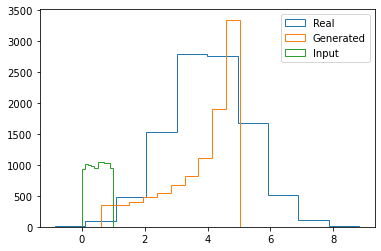

Stage 147 (Epoch: 29400)
Mean and Std of Real: (4.00833731185853, 1.2423817881986445)
Mean and Std of Gen: (3.797041, 1.1810758)


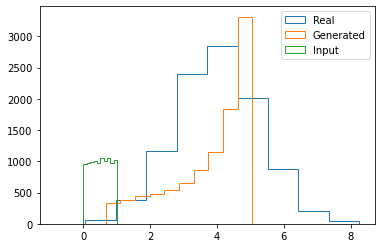

Stage 148 (Epoch: 29600)
Mean and Std of Real: (4.001591628133677, 1.2606639342554404)
Mean and Std of Gen: (3.693309, 1.2275493)


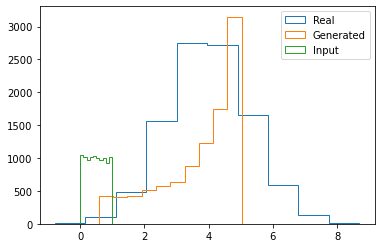

Stage 149 (Epoch: 29800)
Mean and Std of Real: (3.9789364020257656, 1.2585661999593412)
Mean and Std of Gen: (3.94473, 1.1747537)


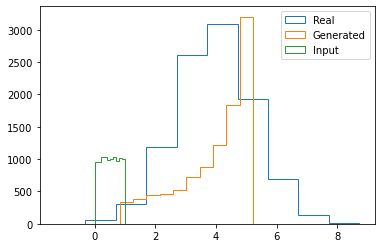

Stage 150 (Epoch: 30000)
Mean and Std of Real: (4.001021506100531, 1.250301177471131)
Mean and Std of Gen: (3.7394426, 1.2479329)


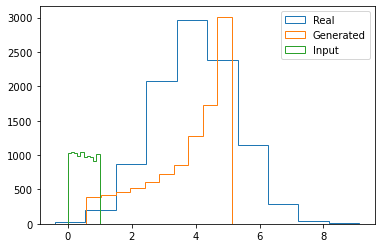

Stage 151 (Epoch: 30200)
Mean and Std of Real: (4.020328429832487, 1.2250870388330364)
Mean and Std of Gen: (3.8491633, 1.2266011)


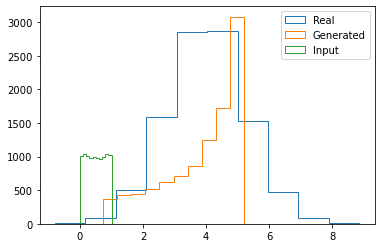

Stage 152 (Epoch: 30400)
Mean and Std of Real: (3.9907946704587944, 1.2537101703247466)
Mean and Std of Gen: (3.7405746, 1.2486928)


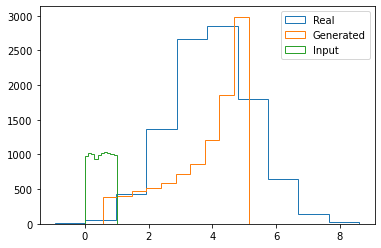

Stage 153 (Epoch: 30600)
Mean and Std of Real: (3.9886790495396003, 1.245266472313262)
Mean and Std of Gen: (3.850769, 1.1672722)


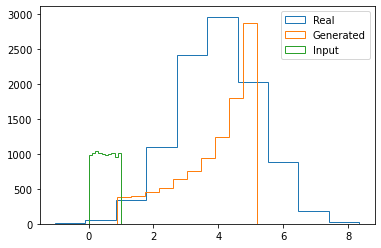

Stage 154 (Epoch: 30800)
Mean and Std of Real: (4.0039197955911145, 1.2421405580359737)
Mean and Std of Gen: (3.8920946, 1.2434982)


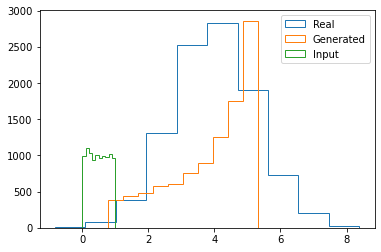

Stage 155 (Epoch: 31000)
Mean and Std of Real: (4.017369290541729, 1.253715301890727)
Mean and Std of Gen: (3.9204457, 1.1957841)


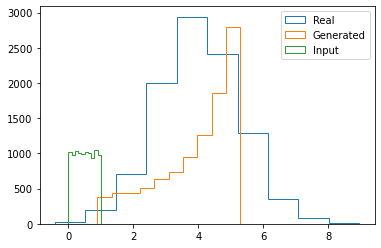

Stage 156 (Epoch: 31200)
Mean and Std of Real: (4.00372496999064, 1.2434617102491694)
Mean and Std of Gen: (3.7342892, 1.2558666)


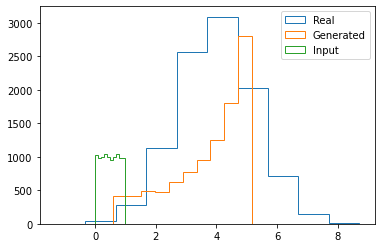

Stage 157 (Epoch: 31400)
Mean and Std of Real: (3.995813362635906, 1.2494494634749818)
Mean and Std of Gen: (3.9685168, 1.1712189)


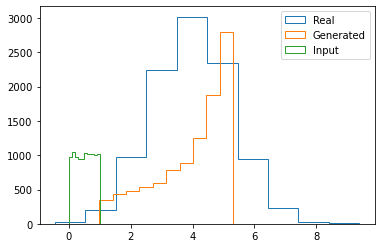

Stage 158 (Epoch: 31600)
Mean and Std of Real: (4.000251166840961, 1.2343030455941297)
Mean and Std of Gen: (3.6493418, 1.2496169)


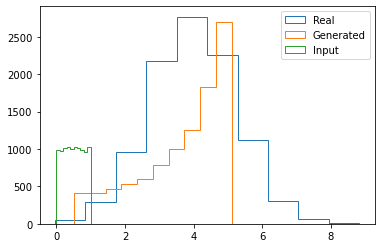

Stage 159 (Epoch: 31800)
Mean and Std of Real: (3.9895284431373, 1.2380549157560699)
Mean and Std of Gen: (3.6724226, 1.2056918)


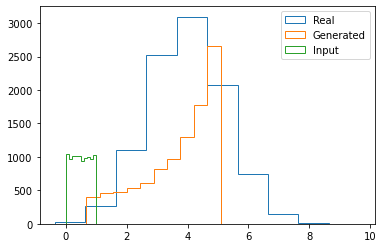

Stage 160 (Epoch: 32000)
Mean and Std of Real: (3.983918517571139, 1.254992624591614)
Mean and Std of Gen: (3.722132, 1.1490313)


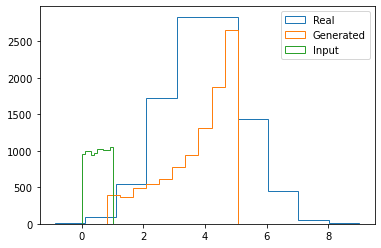

Stage 161 (Epoch: 32200)
Mean and Std of Real: (4.011336320118747, 1.2593776684836513)
Mean and Std of Gen: (3.5997593, 1.2577008)


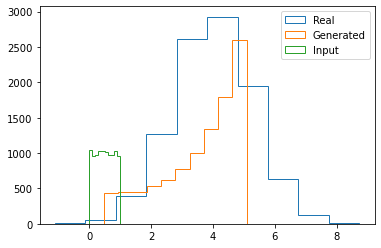

Stage 162 (Epoch: 32400)
Mean and Std of Real: (4.008042684597583, 1.2409552318327315)
Mean and Std of Gen: (3.873419, 1.173707)


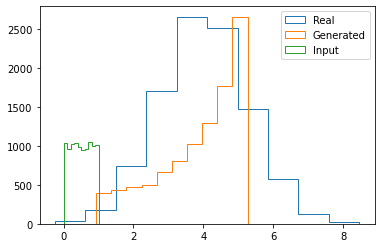

Stage 163 (Epoch: 32600)
Mean and Std of Real: (4.013196141564431, 1.2498408705733248)
Mean and Std of Gen: (3.6827905, 1.26908)


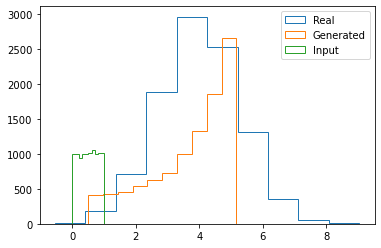

Stage 164 (Epoch: 32800)
Mean and Std of Real: (4.0047768634141185, 1.2533064703433128)
Mean and Std of Gen: (3.9862754, 1.2467629)


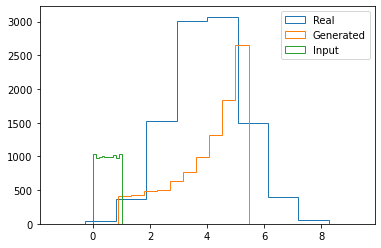

Stage 165 (Epoch: 33000)
Mean and Std of Real: (3.9763123155341846, 1.2359250357481075)
Mean and Std of Gen: (3.8545454, 1.2560174)


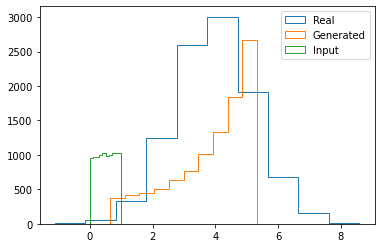

Stage 166 (Epoch: 33200)
Mean and Std of Real: (3.975989576783834, 1.2630184892240306)
Mean and Std of Gen: (3.9845474, 1.213041)


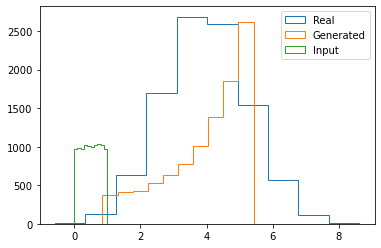

Stage 167 (Epoch: 33400)
Mean and Std of Real: (3.999704607882755, 1.2534306550423748)
Mean and Std of Gen: (3.9077594, 1.3094761)


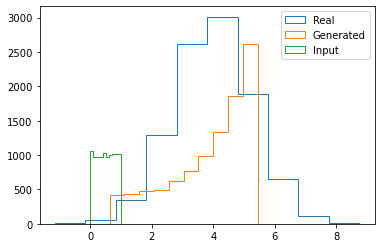

Stage 168 (Epoch: 33600)
Mean and Std of Real: (3.994215252784328, 1.2461980912923107)
Mean and Std of Gen: (4.176343, 1.2446564)


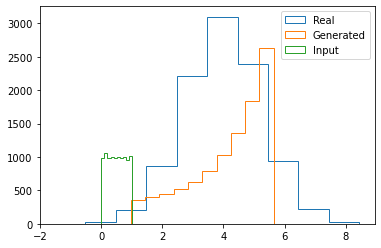

Stage 169 (Epoch: 33800)
Mean and Std of Real: (3.997477576285277, 1.2429730252445212)
Mean and Std of Gen: (3.9631484, 1.2971185)


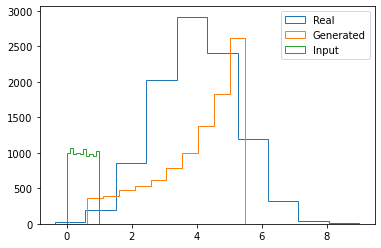

Stage 170 (Epoch: 34000)
Mean and Std of Real: (4.004976663091488, 1.2322817791642613)
Mean and Std of Gen: (3.9250321, 1.212054)


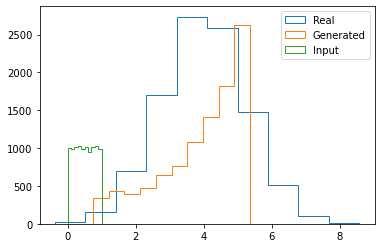

Stage 171 (Epoch: 34200)
Mean and Std of Real: (3.9911716103439443, 1.2578715049186222)
Mean and Std of Gen: (3.9857316, 1.2438895)


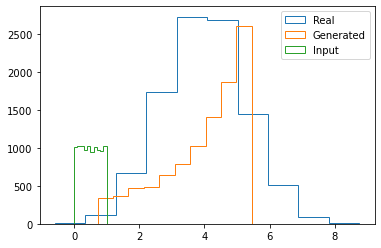

Stage 172 (Epoch: 34400)
Mean and Std of Real: (4.004805611268271, 1.25922396855325)
Mean and Std of Gen: (3.9869516, 1.2853974)


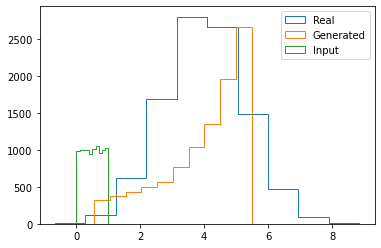

Stage 173 (Epoch: 34600)
Mean and Std of Real: (3.9948434714825636, 1.244988298928807)
Mean and Std of Gen: (4.044588, 1.2307456)


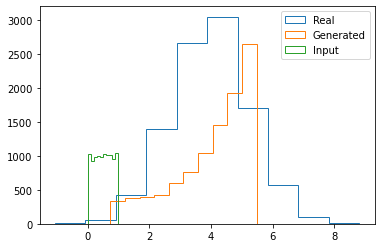

Stage 174 (Epoch: 34800)
Mean and Std of Real: (4.003180667165497, 1.2427214761866126)
Mean and Std of Gen: (3.9006505, 1.2378323)


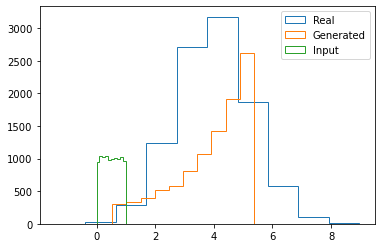

Stage 175 (Epoch: 35000)
Mean and Std of Real: (3.9986063998003227, 1.2495339848287965)
Mean and Std of Gen: (4.108774, 1.2425845)


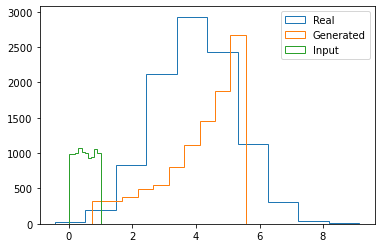

Stage 176 (Epoch: 35200)
Mean and Std of Real: (3.986214387368415, 1.254397044132204)
Mean and Std of Gen: (4.005184, 1.3334206)


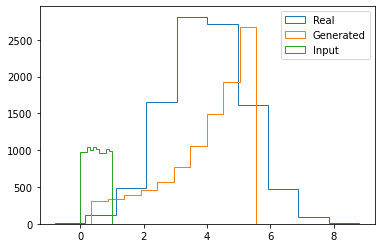

Stage 177 (Epoch: 35400)
Mean and Std of Real: (4.004477836616805, 1.2562612993105187)
Mean and Std of Gen: (4.2528334, 1.2677052)


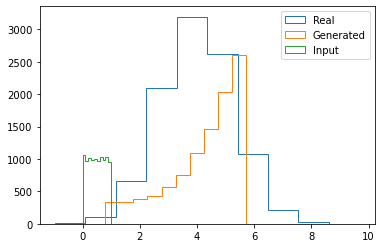

Stage 178 (Epoch: 35600)
Mean and Std of Real: (4.022602020243525, 1.2500220621292977)
Mean and Std of Gen: (4.176545, 1.270091)


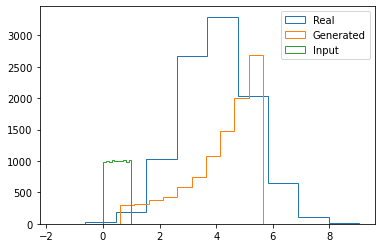

Stage 179 (Epoch: 35800)
Mean and Std of Real: (4.001881439611052, 1.2384625589787592)
Mean and Std of Gen: (4.128874, 1.2779378)


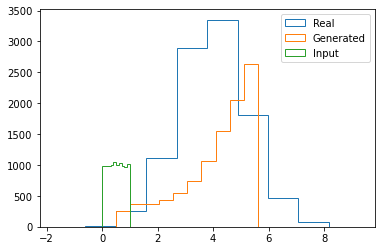

Stage 180 (Epoch: 36000)
Mean and Std of Real: (3.9907868873308767, 1.2558400066396977)
Mean and Std of Gen: (4.2033157, 1.2891322)


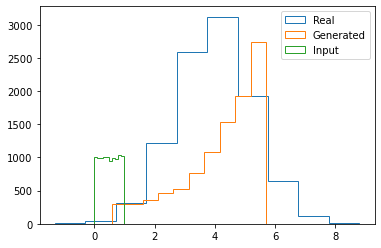

Stage 181 (Epoch: 36200)
Mean and Std of Real: (3.992741490029211, 1.252708747607946)
Mean and Std of Gen: (4.2398477, 1.320159)


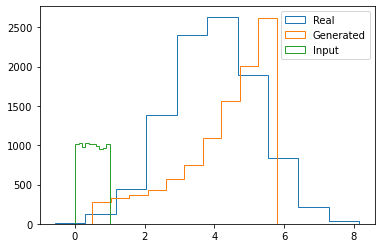

Stage 182 (Epoch: 36400)
Mean and Std of Real: (3.9919383802392585, 1.2542629984795652)
Mean and Std of Gen: (4.2754107, 1.2833664)


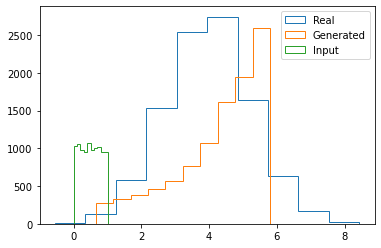

Stage 183 (Epoch: 36600)
Mean and Std of Real: (4.013007852731156, 1.2424794626384896)
Mean and Std of Gen: (4.096648, 1.2932049)


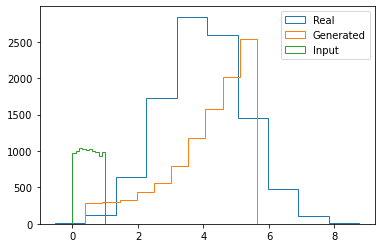

Stage 184 (Epoch: 36800)
Mean and Std of Real: (3.99626746834713, 1.2519918609529272)
Mean and Std of Gen: (4.206438, 1.2021031)


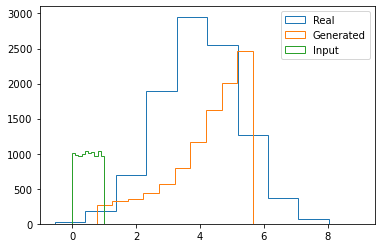

Stage 185 (Epoch: 37000)
Mean and Std of Real: (3.9941859343839954, 1.2470986041152319)
Mean and Std of Gen: (3.991053, 1.341745)


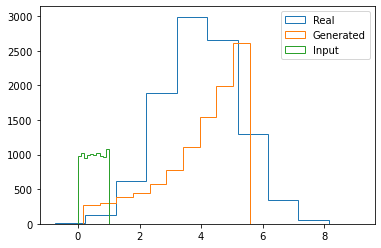

Stage 186 (Epoch: 37200)
Mean and Std of Real: (4.002297176728686, 1.2447111268412052)
Mean and Std of Gen: (4.087434, 1.207833)


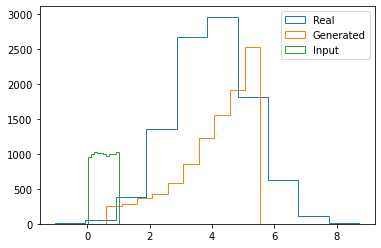

Stage 187 (Epoch: 37400)
Mean and Std of Real: (4.0039383194571965, 1.2404203554722975)
Mean and Std of Gen: (3.9036508, 1.2897744)


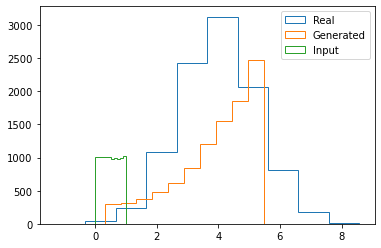

Stage 188 (Epoch: 37600)
Mean and Std of Real: (4.001200195223833, 1.2710525220288635)
Mean and Std of Gen: (4.0282674, 1.2388115)


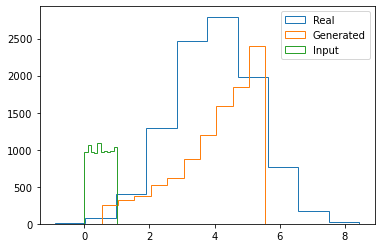

Stage 189 (Epoch: 37800)
Mean and Std of Real: (3.9881549098813855, 1.2540283967735473)
Mean and Std of Gen: (4.073566, 1.2167268)


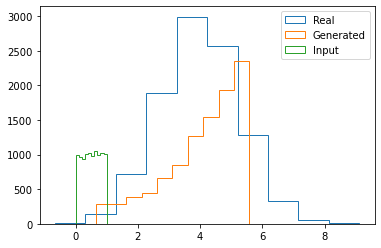

Stage 190 (Epoch: 38000)
Mean and Std of Real: (4.0058690307347, 1.2471698290577022)
Mean and Std of Gen: (3.9310098, 1.2239599)


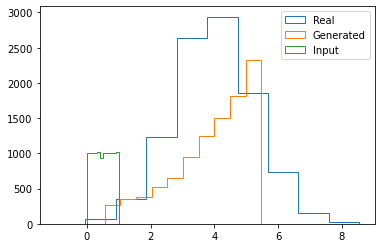

Stage 191 (Epoch: 38200)
Mean and Std of Real: (3.978412458611143, 1.2465112302701735)
Mean and Std of Gen: (3.896961, 1.2535568)


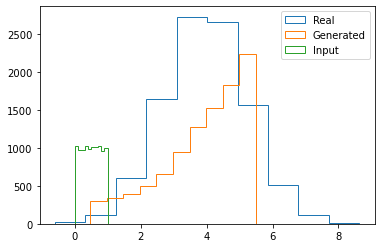

Stage 192 (Epoch: 38400)
Mean and Std of Real: (4.007939235290946, 1.2547787847416758)
Mean and Std of Gen: (4.0087123, 1.2150629)


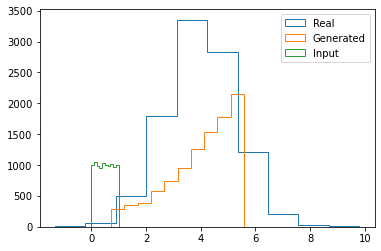

Stage 193 (Epoch: 38600)
Mean and Std of Real: (4.000625078909721, 1.235611970065816)
Mean and Std of Gen: (3.944532, 1.2401015)


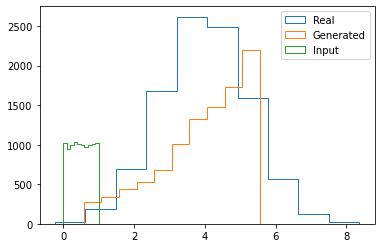

Stage 194 (Epoch: 38800)
Mean and Std of Real: (3.9848961648215715, 1.2482533915865954)
Mean and Std of Gen: (3.785412, 1.2314262)


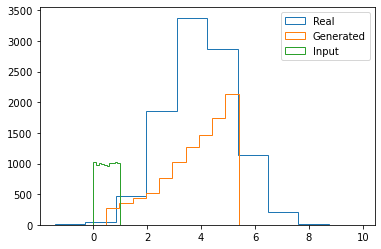

Stage 195 (Epoch: 39000)
Mean and Std of Real: (4.001547431933448, 1.2511327348957588)
Mean and Std of Gen: (3.6403105, 1.2348369)


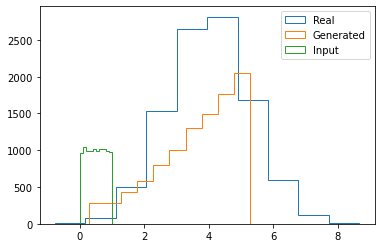

Stage 196 (Epoch: 39200)
Mean and Std of Real: (4.0146455401497985, 1.2377674124489557)
Mean and Std of Gen: (3.6463683, 1.1654093)


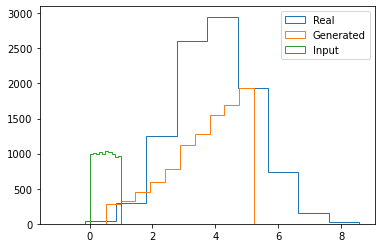

Stage 197 (Epoch: 39400)
Mean and Std of Real: (4.008457969026584, 1.257838697544091)
Mean and Std of Gen: (3.6360242, 1.2318113)


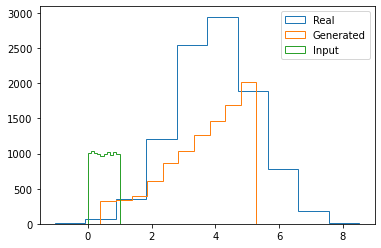

Stage 198 (Epoch: 39600)
Mean and Std of Real: (4.007593124988934, 1.2600976487477438)
Mean and Std of Gen: (3.658991, 1.1949757)


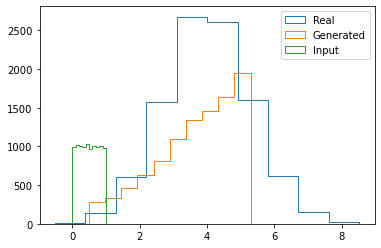

Stage 199 (Epoch: 39800)
Mean and Std of Real: (3.9950689857523556, 1.2522064614613586)
Mean and Std of Gen: (3.531824, 1.1977756)


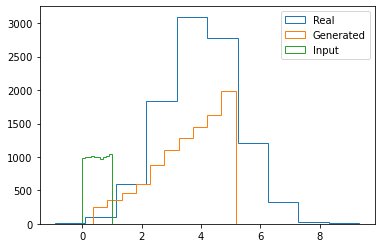

In [9]:
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)


if __name__ == '__main__':
    main()